In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from math import sqrt
import numpy as np
from joblib import dump

def removeMissingRows(df, column_names):
    df = df.dropna(subset=column_names)
    return df

# List of cities
cities = ['Bakersfield', 'Los_Angeles', 'New_York', 'Phoenix', 'Reno', 'Visalia', 'Denver', 'Boston']

# Loop through each city
for city in cities:
    # Load the dataset for each city
    df = pd.read_csv(f'../csv/final_merged_data/merged_data_{city}.csv')
    df = removeMissingRows(df, 'aqi')
    # Define features and target
    numerical_features = ['temp', 'visibility', 'dew_point', 'feels_like', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'wind_gust', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_id', 'year', 'month', 'day']
    X = df[numerical_features]
    y = df['aqi']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a pipeline for preprocessing and regression
    elastic_net_pipeline = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42))
    ])

    # Train the model
    elastic_net_pipeline.fit(X_train, y_train)

    # Predict using the model
    y_pred = elastic_net_pipeline.predict(X_test)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Output the performance metrics
    print(f"City: {city}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R^2 Score: {r2}")

    # Save the trained model and results
    dump(elastic_net_pipeline, f'elastic_net_model_{city}.joblib')
    with open(f'elastic_net_results_{city}.txt', 'w') as file:
        file.write(f"Mean Squared Error (MSE): {mse}\n")
        file.write(f"Root Mean Squared Error (RMSE): {rmse}\n")
        file.write(f"R^2 Score: {r2}\n")



KeyError: 'elasticnet'

               Feature  Average Coefficient
weather_id  weather_id             0.359577
pressure      pressure             0.203461
month            month             0.144373
humidity      humidity             0.043148
wind_gust    wind_gust             0.016655
day                day            -0.006954
snow_1h        snow_1h            -0.024810
clouds_all  clouds_all            -0.132381
visibility  visibility            -0.152194
rain_1h        rain_1h            -0.153695
wind_deg      wind_deg            -0.206838
dew_point    dew_point            -0.594835
feels_like  feels_like            -0.725842
temp              temp            -1.033370
wind_speed  wind_speed            -1.146177
year              year            -2.263800


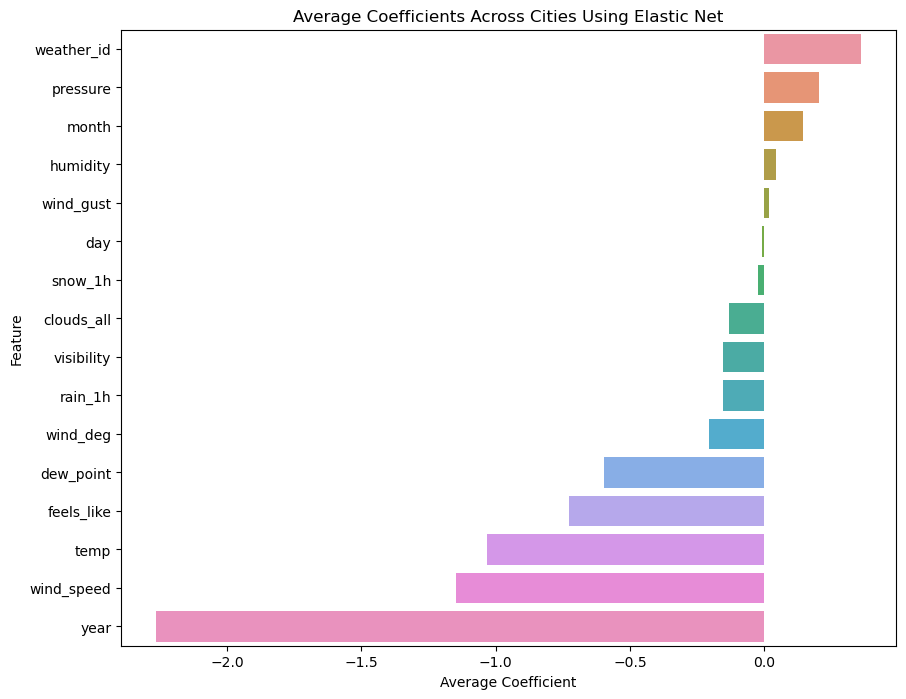

In [7]:
from joblib import load
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

cities = ['Bakersfield', 'Los_Angeles', 'New_York', 'Phoenix', 'Reno', 'Visalia', 'Denver', 'Boston']
features = ['temp', 'visibility', 'dew_point', 'feels_like', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'wind_gust', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_id', 'year', 'month', 'day']

# Initialize a DataFrame to store feature coefficients across all cities
coef_data = pd.DataFrame(columns=features)

for city in cities:
    # Load the pre-trained elastic net model within a pipeline
    pipeline = load(f'../results/elastic_net/elastic_net_model_{city}.joblib')

    # Access the ElasticNet model specifically (named 'regressor' in the pipeline)
    en_model = pipeline.named_steps['regressor']

    # Get coefficients from the Elastic Net model
    coefficients = en_model.coef_

    # Add current city's coefficients to the DataFrame
    coef_data.loc[city] = coefficients

# Calculate the average coefficient for each feature across all cities
average_coefficients = coef_data.mean(axis=0)

# Create a DataFrame from the average coefficients
average_coefficients_df = pd.DataFrame({'Feature': features, 'Average Coefficient': average_coefficients})

# Sort features by average coefficient
average_coefficients_df = average_coefficients_df.sort_values(by='Average Coefficient', ascending=False)
print(average_coefficients_df)
# Create a bar plot of average feature coefficients
plt.figure(figsize=(10, 8))
sns.barplot(x='Average Coefficient', y='Feature', data=average_coefficients_df)
plt.title('Average Coefficients Across Cities Using Elastic Net')
plt.xlabel('Average Coefficient')
plt.ylabel('Feature')
plt.show()
